In [1]:
import pandas as pd
import os 
import csv
import pickle
import gzip
import matplotlib as mpl
import matplotlib.pyplot as plt
import graph_tool.all as gt
from config import TWITTER_DATA_DIR
from config import FOLLOWER_DATA_DIR
from cascade import Cascade
from tweet import Tweet, MissingTweet
from wand.image import Image as WImage

In [2]:
%load_ext autoreload
%autoreload 2

# Load Tweet Time Series Data

In [3]:
with open(os.path.join(TWITTER_DATA_DIR, 'campaign_tweets_new.pkl'), 'rb') as f:
    campaigns = pickle.load(f)
    # dict: hashtag -> tweets

# Load User Data

In [4]:
with open(os.path.join(TWITTER_DATA_DIR, 'users.pkl'), 'rb') as f:
    user_df = pickle.load(f)

# Using Time to Infer Retweet Network

In [5]:
def process_tweet_ts(tts):
    """Constructs RT cascades from time series of tweets
    Input:
    tts (list[dict]): list of tweets forming a time series
    
    Output:
    depth_one_rts (dict: str -> list[dict]): dictionary mapping tweet ids to a list of tweet ids that retweeted
    ids_to_tweets (dict: str -> dict): dictionary mapping tweet ids to full tweet dicts
    """
    
    tts = sorted(tts, key=lambda x: x['date'])
    depth_one_rts = {}
    ids_to_tweets = {}
    for tweet in tts:
        ids_to_tweets[tweet['id']] = Tweet(tweet)
        rt_id = tweet['retweet_id']
        if rt_id == '': # this is an original tweet
            depth_one_rts[tweet['id']] = []
        else:
            rts = depth_one_rts.get(rt_id, list())
            rts.append(tweet['id'])
            depth_one_rts[rt_id] = rts
    return depth_one_rts, ids_to_tweets

In [6]:
def parse_cascades(depth_one_rts, ids_to_tweets):
    """ Turns output of process_tweet_ts into a list of Cascade objects
    Input: 
    depth_one_rts (dict: str -> list[dict]): dictionary mapping tweet ids to a list of tweet ids that retweeted
    ids_to_tweets (dict: str -> dict): dictionary mapping tweet ids to full tweet dicts

    Output:
    cascades (list[Cascade]): list of Cascade objects
    """
    cascades = []
    for root_id, follower_ids in depth_one_rts.items():
        try:
            root = ids_to_tweets[root_id]
            retweets = [ids_to_tweets[x] for x in follower_ids]
            cascades.append(Cascade(root, retweets))
        except:
            continue 
            #print('missing info related to root ', root_id, ' or followers ', ','.join(follower_ids))
    return cascades

# Extracting Largest Cascades

In [7]:
def extract_cascades(top_n=5, min_size=0, debug=False):
    """Extracts cascades from campaign
    Inputs:
    top_n (int): extracts top n cascades from a particular hashtag
    min_size (int): only extracts cascades of at least this size
    debug (bool): if true, only runs on first campaign
    """
    top_cascades = []
    for tag, tweets in campaigns.items():
        temp = parse_cascades(*process_tweet_ts(tweets.values()))
        temp = [x for x in temp if x.n_retweets > min_size]
        top_cascades += sorted(temp, key=lambda x: -x.n_retweets)[:top_n]
        if debug:
            break
    return top_cascades

In [8]:
top_cascades = extract_cascades(top_n=100, min_size=30)

# Get Cascade Statistics

In [60]:
def get_top_tweets(g, thresh=5):
    # returns tweets that had an outdegree > 5
    locs = np.where(g.get_out_degrees(g.get_vertices()) > thresh)
    return [g.vp.vertex_to_tweet[v] for v in locs[0]]

def get_user_type(username):
    if username in user_df.index:
        return user_df.loc[username].type
    else:
        return "Unknown"
    
def tweet_list_to_df(tweet_list):
    # takes list of tweet objects and turns it into a pandas df
    res = pd.DataFrame({tweet.id: tweet.__dict__ for tweet in tweet_list}).T
    res = res.drop(columns=['id', 'retweet_id'])
    res.index.name = 'tweet_id'
    res['user_type'] = res.username.apply(get_user_type)
    return res

In [61]:
top_users = [user for c in top_cascades for user in get_top_tweets(c.create_temporal_cascade())]

In [82]:
tweet_list_to_df(top_users)

,username,date,text,favorites,retweets,retweet_from,template,user_type
tweet_id,,,,,,,,
1088015885376409600,chotivalebaba,2019-01-23 10:09:36,"देवियो और सज्जनो, राहुल गांधी... #amethikididi...",766,335,,,6_non-participant
1088020422879150080,tajinderbagga,2019-01-23 10:27:37,"rt @chotivalebaba: देवियो और सज्जनो, राहुल गां...",0,362,chotivalebaba,,6_non-participant
1088024935690194944,nikhildadhich,2019-01-23 10:45:33,"rt @chotivalebaba: देवियो और सज्जनो, राहुल गां...",0,362,chotivalebaba,,3_fan
1088095162826477571,mssirsa,2019-01-23 15:24:37,देश को “नाम वाली दीदी” नही चाहिये... काम वाली ...,1271,442,,,6_non-participant
1088109326957535232,ibhagwa_n,2019-01-23 16:20:54,rt @mssirsa: देश को “नाम वाली दीदी” नही चाहिये...,0,431,mssirsa,,3_fan
...,...,...,...,...,...,...,...,...
1100407361930293254,byadavbjp,2019-02-26 14:48:54,rt @amitshah: गाजीपुर (उत्तर प्रदेश) के मौजा-ग...,0,2363,amitshah,,6_non-participant
1100424375025557510,ramlal,2019-02-26 15:56:30,rt @amitshah: गाजीपुर (उत्तर प्रदेश) के मौजा-ग...,0,2363,amitshah,,6_non-participant
1100432559580708864,bjp4mp,2019-02-26 16:29:01,rt @amitshah: गाजीपुर (उत्तर प्रदेश) के मौजा-ग...,0,2363,amitshah,,6_non-participant


In [83]:
root_tweets = [c.root for c in top_cascades]
tweet_list_to_df(root_tweets)

,username,date,text,favorites,retweets,retweet_from,template,user_type
tweet_id,,,,,,,,
1088015885376409600,chotivalebaba,2019-01-23 10:09:36,"देवियो और सज्जनो, राहुल गांधी... #amethikididi...",766,335,,,6_non-participant
1088095162826477571,mssirsa,2019-01-23 15:24:37,देश को “नाम वाली दीदी” नही चाहिये... काम वाली ...,1271,442,,,6_non-participant
1088041569502978048,changeamethi,2019-01-23 11:51:39,आधारभूत सेवाओं के लिए तरसता अमेठी amethi @offi...,3,2,,,6_non-participant
1087994597207408641,manesha76,2019-01-23 08:45:00,dalit of amethi with @smritiirani #amethikidid...,67,37,,,1_itcell
1122492960757575682,changeamethi,2019-04-28 13:29:11,@ektaravikapoor @smritiirani #amethiwithsmriti...,6,2,,,6_non-participant
...,...,...,...,...,...,...,...,...
1107280408041816065,bjym,2019-03-17 13:59:56,भ्रष्ट को कष्ट है इसलिए #chowkidarphirse #लक्ष...,1044,283,,,6_non-participant
1106947987836715008,bjym,2019-03-16 15:59:01,#mainbhichowkidar #लक्ष्य_हमारा_मोदी_दोबारा @p...,763,234,,,6_non-participant
1106548687633870851,bjym,2019-03-15 13:32:20,करारी हार आपका पीछा कर रही है साहेब! @narendra...,805,287,,,6_non-participant


In [276]:
participant_to_color = {'6_non-participant': 6, '2_official': 2, '3_fan': 3,
                        '1_itcell': 1, '5_deleted': 5, '4_other': 4}

def plot_temporal_cascade(g, text_label_thresh=5, output_name=None):
    """ Plots a temporal cascade
    Input:
    g (gt.Graph): graph to plot
    
    Optional inputs:
    output_name (string): name for output file
    text_label_thresh (int): if out degree > this, username will be labeled
    """
    vtext = g.new_vertex_property('string')
    for v in g.vertices():
        vtext[v] = ''
        if v.out_degree() > text_label_thresh:
            vtext[v] = g.vp.vertex_to_tweet[v].username
    
    vcolor = color_nodes(g)
    out_deg = g.new_vertex_property('int')
    out_deg.a = np.log(g.get_out_degrees(g.get_vertices())+2)
    output_file = f'plots/{output_name}.pdf' if output_name else 'plots/temp.pdf'
    gt.graphviz_draw(g, layout='dot', output=output_file,
                    vcolor=vcolor, vcmap=matplotlib.cm.jet,
                    vsize=out_deg,
                     vprops={"label": vtext,'fontsize': 100}, size=(60,60))
    return WImage(filename=output_file)

def color_nodes(g):
    # returns a VertexPropertyMap with colorings by a user attribute
    colors = g.new_vertex_property('int')
    for v in g.vertices():
        tweet = g.vp.vertex_to_tweet[v]
        if tweet.username in user_df.index:
            colors[v] = participant_to_color[user_df.loc[tweet.username].type]
    return colors

In [ ]:
for c in top_cascades:
    g = c.create_temporal_cascade()
    name = f'{c.root.username}-{c.n_retweets}'
    plot_temporal_cascade(g, output_name=name)

chotivalebaba
tajinderbagga
nikhildadhich
mssirsa
ibhagwa_n
madhusharmabjp
tanhadil1981
changeamethi
shrikantamethi
changeamethi
manesha76
shehzad_ind
changeamethi
nikhildadhich
akshaysinghel
nikhildadhich
ipurohitharshal
ankitasood13
amitmalviya
ibhagwa_n
anil_baluni
akshaysinghel
bjp4stmorcha
punitspeaks
madhusharmabjp
congressdahan
sanghaviharsh
prafullaketkar
sagenaradamuni
kuljeetschahal
seematrivedi6
mahaveerm_
lillymarypinto
bjp4india
sambitswaraj
bjp4rajasthan
bjp4assam
bjp4india
jpnadda
bjp4assam
bjp4uk
bjp4andhra
klnbjp
bjp4atp
gopinathravilla
klnbjp
bjp4ctr
sunil_deodhar
karunagopal1
klnbjp
haribabubjp
bjp4krishna1
sunil_deodhar
reema_bjp
ankitsh47199843
sunil_deodhar
bjp4andhra
bjp4mp
insan_honey
vipassanainsan
nazrana_bhagu
vandanagarg978
pargatbhagu
sukhleantinsan
insanshobha
itwingdss
vipassanainsan
pargatbhagu
renuds121_renu
pmoindia
bjp4uk
naqvimukhtar
ddnational
nsitharaman
rajeev_mp
nsitharamanoffc
hindustanse
cmofficeup
suryavanshi8888
roohemeet
vipassanainsan
insan

chotivalebaba
tajinderbagga
nikhildadhich


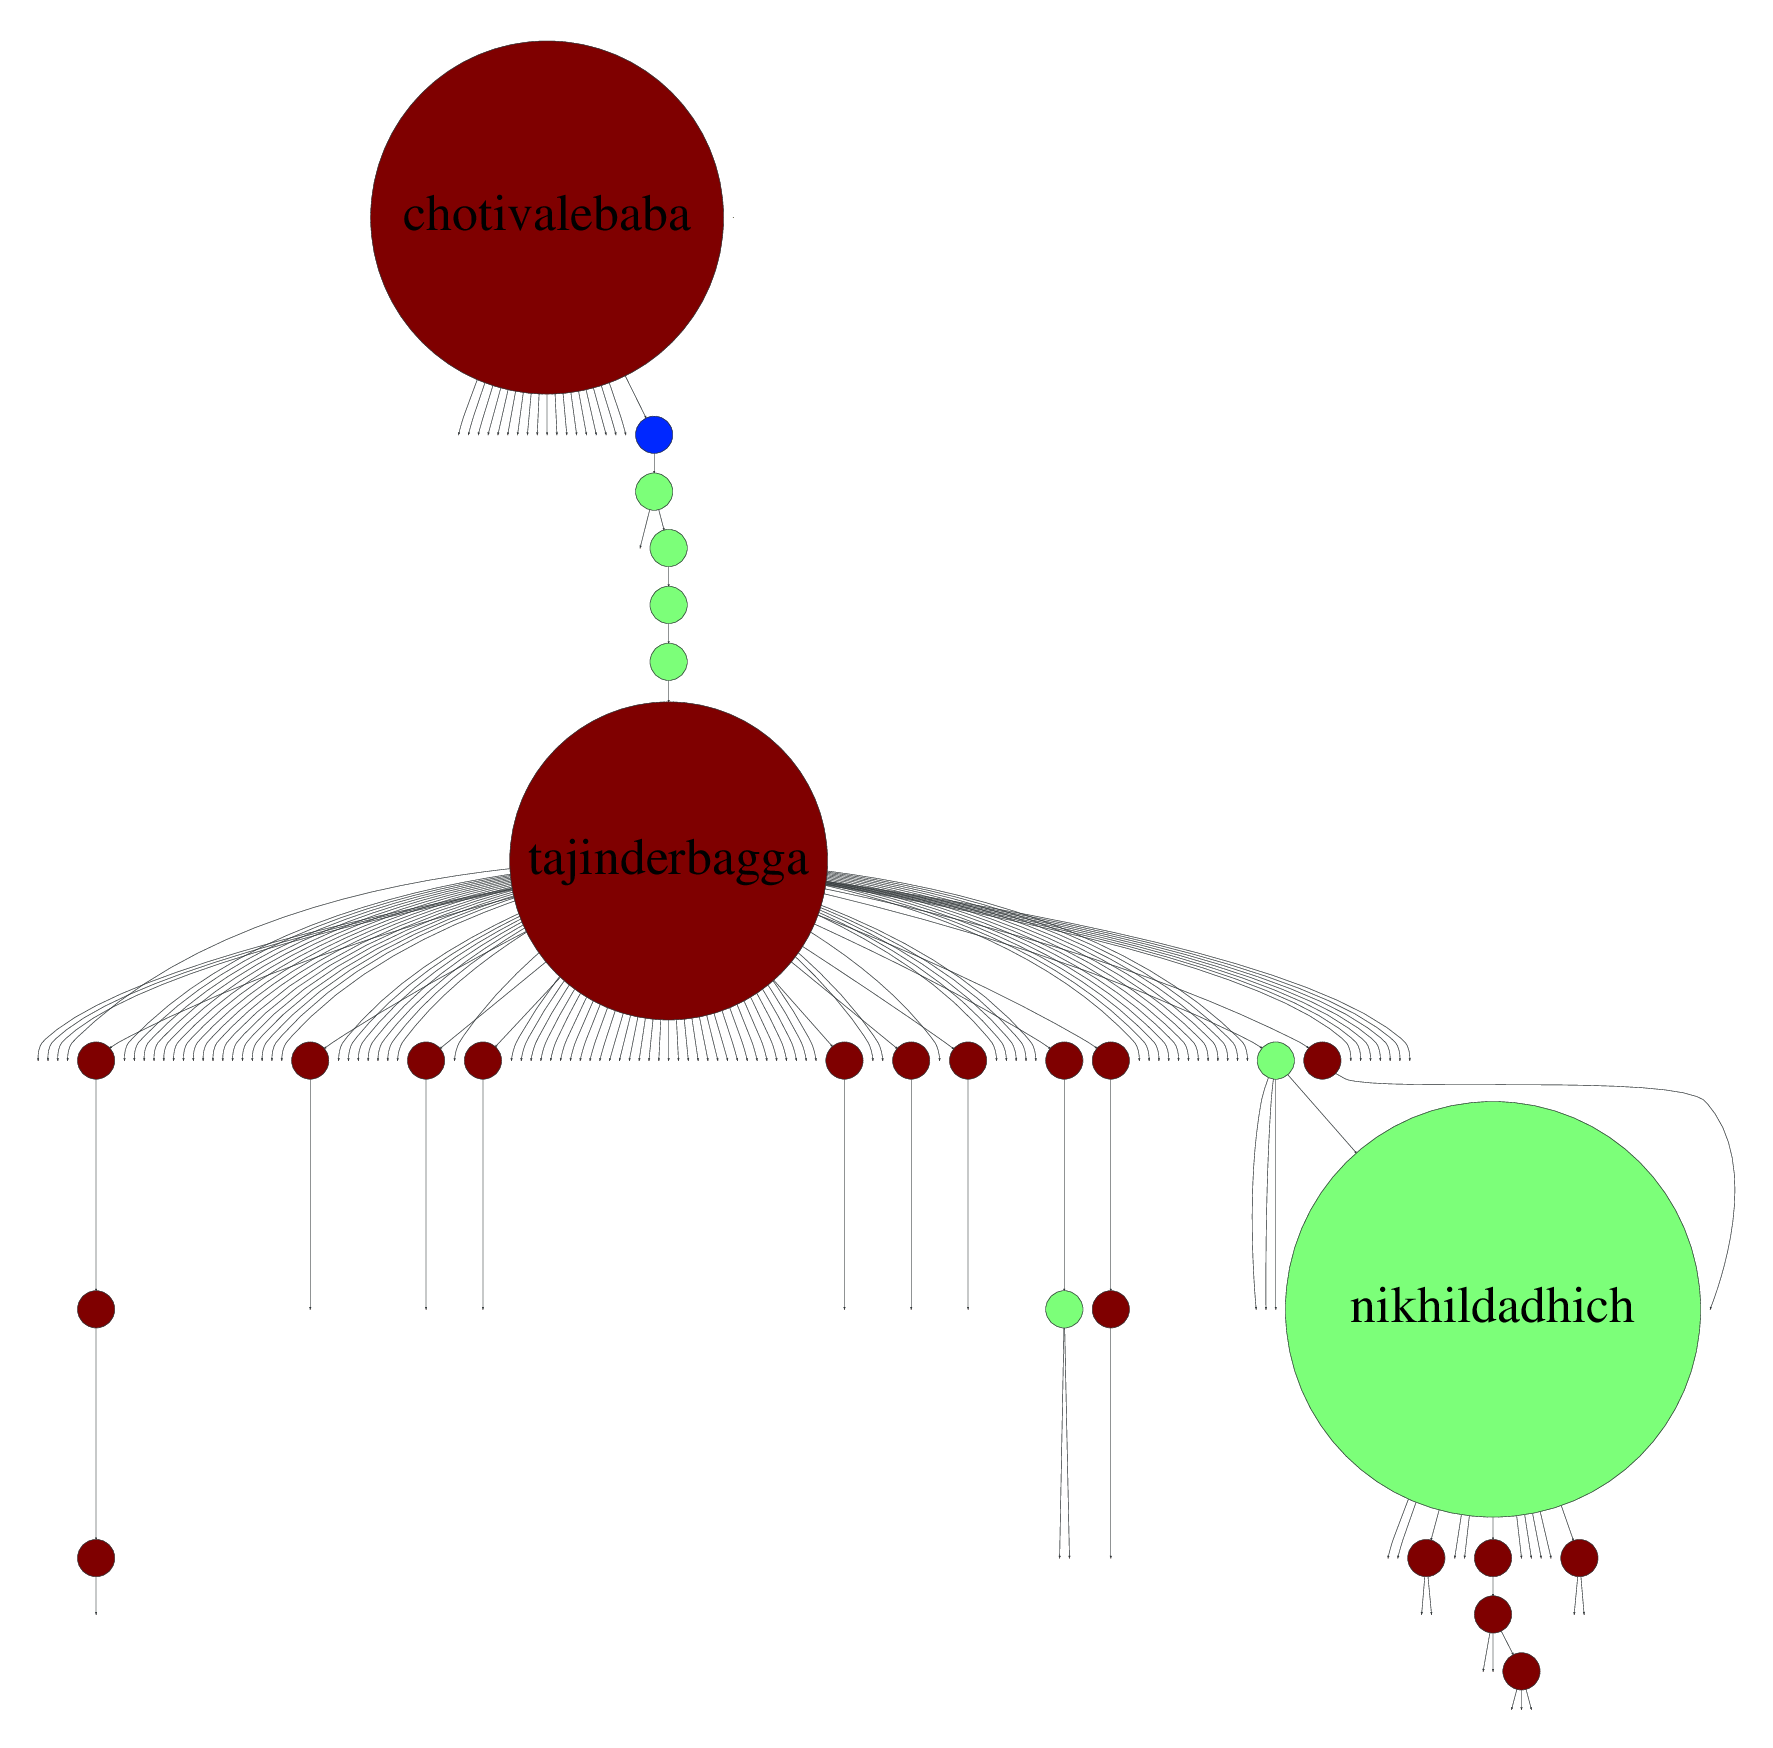

In [277]:
plot_temporal_cascade(g)

In [194]:
def show_color_bar(dic, cmap=plt.cm.jet):
    labels = [x[2:] for x in sorted(dic.keys())]
    fig, ax = plt.subplots(1, 1, figsize=(.5, 6))  # setup the plot

    # define the bins and normalize
    bounds = np.linspace(0, len(labels), 7)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm,
        spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
    new_tick_locs = [x+.5 for x in bounds]
    cb.set_ticks(new_tick_locs[:-1])
    cb.set_ticklabels(labels)

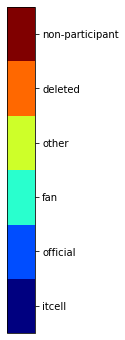

In [196]:
show_color_bar(participant_to_color)

## Collecting High Influence Nodes

In [10]:
test = top_cascades[0]

### Installing Conda Packages from Notebook

In [17]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge wand

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/jschless/.conda/envs/gt:

The following NEW packages will be INSTALLED:

    fftw:                      3.3.8-nompi_h7f3a6c3_1111 conda-forge
    font-ttf-dejavu-sans-mono: 2.37-hab24e00_0           conda-forge
    font-ttf-inconsolata:      2.001-hab24e00_0          conda-forge
    font-ttf-source-code-pro:  2.030-hab24e00_0          conda-forge
    font-ttf-ubuntu:           0.83-hab24e00_0           conda-forge
    fonts-conda-forge:         1-0                       conda-forge
    ghostscript:               9.22-hf484d3e_1001        conda-forge
    giflib:                    5.2.1-h516909a_2          conda-forge
    graphviz:                  2.42.3-h0511662_0         conda-forge
    imagemagick:               7.0.10_24-pl526h201ca68_0 conda-forge
    jbig:                      2.1-h516909a_2002         conda-forge
    libtool:                   2.4.6-h14c397